# RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval

[RAPTOR](https://arxiv.org/pdf/2401.18059.pdf) 논문은 문서의 색인 생성 및 검색에 대한 흥미로운 접근 방식을 제시합니다.

[테디노트 논문 요약글(노션)](https://teddylee777.notion.site/RAPTOR-e835d306fc664dc2ad76191dee1cd859?pvs=4)

- `leafs` 는 가장 low-level 의 시작 문서 집합입니다. 이 문서들은 임베딩되어 클러스터링됩니다.
- 그런 다음 클러스터는 유사한 문서들 간의 정보를 더 높은 수준(더 추상적인)으로 요약합니다.

이 과정은 재귀적으로 수행되어, 원본 문서(`leafs`)에서 더 추상적인 요약으로 이어지는 "트리"를 형성합니다.

`leafs`는 다음과 같은 문서들로 구성될 수 있습니다.

- 단일 문서에서의 텍스트 청크(논문에서 보여준 것처럼)
- 전체 문서(아래에서 보여주는 것처럼)

이번 튜토리얼에서는 긴 문서(PDF) 에 대해서 RAPTOR 방법론을 적용해 보도록 하겠습니다.


## 실습에 활용한 문서

소프트웨어정책연구소(SPRi) - 2023년 12월호

- 저자: 유재흥(AI정책연구실 책임연구원), 이지수(AI정책연구실 위촉연구원)
- 링크: https://spri.kr/posts/view/23669
- 파일명: `SPRI_AI_Brief_2023년12월호_F.pdf`

_실습을 위해 다운로드 받은 파일을 `data` 폴더로 복사해 주시기 바랍니다_


## 환경 설정

**추가 패키지 설치**

아래 주석을 해제하고 실행하여 추가 패키지를 설치 후 진행해 주세요.

In [1]:
# !pip install -U umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 38.0 MB/s eta 0:00:00a 0:00:01


상단의 **restart** 버튼을 눌러 재시작 한 뒤 다시 처음부터 진행해 주세요.

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv
import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore")

# API 키 정보 로드
load_dotenv()

True

## 데이터 전처리

`doc`은 PDF 파일입니다. 토큰 수는 100 토큰 미만에서 10,000 토큰 이상까지 다양합니다.

웹 문서에서 텍스트 데이터를 추출하고, 텍스트의 토큰 수를 계산하여 히스토그램으로 시각화합니다.

문서의 페이지수: 23


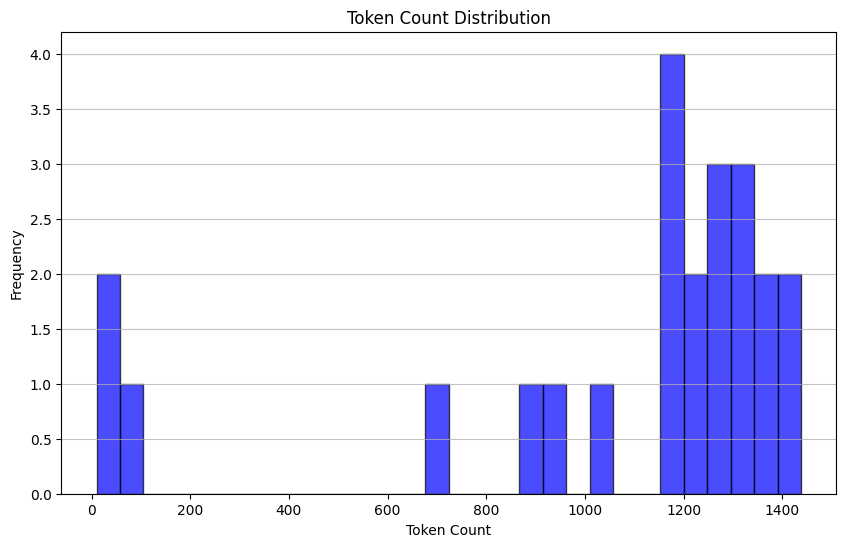

In [2]:
from langchain_community.document_loaders import PDFPlumberLoader
import tiktoken
import matplotlib.pyplot as plt


# 토큰 수 계산
def num_tokens_from_string(string: str, encoding_name: str):
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


# 문서 로드(Load Documents)
loader = PDFPlumberLoader("data/SPRI_AI_Brief_2023년12월호_F.pdf")
docs = loader.load()
print(f"문서의 페이지수: {len(docs)}")

# 문서 텍스트
docs_texts = [d.page_content for d in docs]

# 각 문서에 대한 토큰 수 계산
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# 토큰 수의 히스토그램을 그립니다.
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# 히스토그램을 표시합니다.
plt.show()

문서 텍스트를 정렬합니다. 이때 메타데이터의 `source` 를 기준으로 정렬한 뒤, 모든 문서를 연결합니다.

In [3]:
# 문서를 출처 메타데이터 기준으로 정렬합니다.
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# 역순으로 배열된 문서의 내용을 연결합니다.
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

print(
    "전체 토큰 수: %s"  # 모든 문맥에서의 토큰 수를 출력합니다.
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

전체 토큰 수: 24131


`RecursiveCharacterTextSplitter`를 사용하여 텍스트를 분할합니다.

In [4]:
# 텍스트 분할을 위한 코드
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 기준 토큰수
chunk_size = 100

# 텍스트 분할기 초기화
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size, chunk_overlap=0
)

# 주어진 텍스트를 분할
texts_split = text_splitter.split_text(concatenated_content)

다음으로는 분할된 chunk 들을 임베딩하여 vector store 에 저장합니다.

In [5]:
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore

# cache 저장 경로 지정
store = LocalFileStore("./cache/")

# embeddings 인스턴스를 생성
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", disallowed_special=())

# CacheBackedEmbeddings 인스턴스를 생성
cached_embeddings = CacheBackedEmbeddings.from_bytes_store(
    embeddings, store, namespace=embeddings.model
)

## 모델 설정

In [6]:
from langchain_openai import ChatOpenAI


# llm 모델 초기화
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
)

## 트리 구축

트리 구축에서의 클러스터링 접근 방식에 대한 주요 개요입니다.

**GMM (가우시안 혼합 모델)**

- 다양한 클러스터에 걸쳐 데이터 포인트의 분포를 모델링합니다.
- 모델의 베이지안 정보 기준(BIC)을 평가하여 최적의 클러스터 수를 결정합니다.

**UMAP (Uniform Manifold Approximation and Projection)**

- 클러스터링을 지원합니다.
- 고차원 데이터의 차원을 축소합니다.
- UMAP은 데이터 포인트의 유사성에 기반하여 자연스러운 그룹화를 강조하는 데 도움을 줍니다.

**지역 및 전역 클러스터링**

- 데이터를 저차원으로 차원 축소하여 클러스터링을 수행합니다.

**임계값 설정**

- GMM의 맥락에서 클러스터 멤버십을 결정하기 위해 적용됩니다.
- 확률 분포를 기반으로 합니다(데이터 포인트를 ≥ 1 클러스터에 할당).

---

GMM 및 임계값 설정에 대한 코드는 아래 두 출처에서 언급된 Sarthi et al의 것입니다. 

**참조**

- [원본 저장소](https://github.com/parthsarthi03/raptor/blob/master/raptor/cluster_tree_builder.py)
- [소소한 조정](https://github.com/run-llama/llama_index/blob/main/llama-index-packs/llama-index-packs-raptor/llama_index/packs/raptor/clustering.py)

### 차원 축소

`global_cluster_embeddings`

- 입력된 임베딩 벡터를 전역적으로 차원 축소하기 위해 UMAP을 적용합니다. 전역적으로 차원을 축소한 결과물을 얻어 추후 클러스터링에 활용합니다.

**과정**

- n_neighbors: UMAP에 사용될 이웃(neighbor) 수를 정합니다. 데이터 포인트 하나를 이해할 때 주변 데이터 포인트 개수를 나타냅니다. 입력이 없으면 데이터 개수에 따라 자동으로 계산합니다.
- umap.UMAP(...)를 사용하여, 고차원 임베딩을 dim 차원으로 축소합니다.
- 축소된 벡터들은 전역적(global)인 구조 파악에 도움이 되는 저차원 표현입니다.

---

`local_cluster_embeddings`

- 선택한 데이터 부분집합에 대해 로컬(국소적) 차원 축소를 수행합니다.

**과정**

- 글로벌 차원 축소와 유사하지만, 로컬 차원 축소는 이미 한 번 전역 클러스터링을 통해 추출한 특정 그룹(글로벌 클러스터) 내 데이터에 대해 다시 UMAP을 적용합니다.
- 이 과정은 전역적으로 파악된 큰 구조 안에서 더 세밀한 클러스터 구조를 파악하는 데 도움이 됩니다.

In [7]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 42  # 재현성을 위한 고정된 시드 값


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """전역적으로 임베딩 벡터의 차원을 축소하는 함수입니다.

    Args:
        embeddings (np.ndarray): 차원을 축소할 임베딩 벡터들
        dim (int): 축소할 차원의 수
        n_neighbors (Optional[int], optional): UMAP에서 사용할 이웃의 수. 기본값은 None으로, 이 경우 데이터 크기에 따라 자동 계산됨
        metric (str, optional): 거리 계산에 사용할 메트릭. 기본값은 "cosine"

    Returns:
        np.ndarray: 차원이 축소된 임베딩 벡터들
    """
    # 이웃 수 계산
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)

    # UMAP 적용
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """로컬(국소적)하게 임베딩 벡터의 차원을 축소하는 함수입니다.

    Args:
        embeddings (np.ndarray): 차원을 축소할 임베딩 벡터들
        dim (int): 축소할 차원의 수
        num_neighbors (int, optional): UMAP에서 사용할 이웃의 수. 기본값은 10
        metric (str, optional): 거리 계산에 사용할 메트릭. 기본값은 "cosine"

    Returns:
        np.ndarray: 차원이 축소된 임베딩 벡터들
    """
    # UMAP 적용
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

### 최적의 클러스터 수 계산

`get_optimal_clusters` 

- 주어진 임베딩 데이터에 대해 가장 적절한 클러스터 수를 BIC 점수를 기반으로 결정합니다.
- GMM과 BIC를 활용해 클러스터 개수를 자동으로 결정하므로, 사전에 클러스터 수를 지정할 필요가 없습니다.

**과정**

- 가능한 클러스터 수(1 ~ max_clusters 사이)를 순회하며 각 클러스터 개수로 GMM을 학습합니다.
- 각 GMM에 대해 BIC 점수를 계산한 뒤 리스트에 저장합니다.
- BIC 점수가 가장 낮은(가장 좋은 성능을 보이는) 클러스터 개수를 선택하여 반환합니다.

In [8]:
def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """BIC 점수를 기반으로 최적의 클러스터 수를 찾는 함수입니다.

    Args:
        embeddings (np.ndarray): 클러스터링할 임베딩 벡터들
        max_clusters (int, optional): 탐색할 최대 클러스터 수. 기본값은 50
        random_state (int, optional): 난수 생성을 위한 시드값. 기본값은 RANDOM_SEED

    Returns:
        int: BIC 점수가 가장 낮은(최적의) 클러스터 수
    """
    # 최대 클러스터 수와 임베딩의 길이 중 작은 값을 최대 클러스터 수로 설정
    max_clusters = min(max_clusters, len(embeddings))
    # 1부터 최대 클러스터 수까지의 범위를 생성
    n_clusters = np.arange(1, max_clusters)

    # BIC 점수를 저장할 리스트
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        # 학습된 모델의 BIC 점수를 리스트에 추가
        bics.append(gm.bic(embeddings))

    # BIC 점수가 가장 낮은 클러스터 수를 반환
    return n_clusters[np.argmin(bics)]

### 클러스터링 수행

`GMM_cluster` 

- GMM을 이용해 주어진 임베딩에 대해 클러스터를 할당합니다.

**과정**

- `get_optimal_clusters` 를 통해 최적의 클러스터 수를 찾습니다.
- `GaussianMixture` 모델을 해당 클러스터 수로 학습합니다.
- 각 데이터 포인트가 각 클러스터에 속할 확률(predict_proba)을 구합니다.
- 주어진 threshold를 바탕으로, 확률이 임계값을 초과하는 클러스터만 레이블로 할당합니다.

In [9]:
def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    # 최적의 클러스터 수 산정
    n_clusters = get_optimal_clusters(embeddings)

    # 가우시안 혼합 모델을 초기화
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)

    # 임베딩이 각 클러스터에 속할 확률을 예측
    probs = gm.predict_proba(embeddings)

    # 임계값을 초과하는 확률을 가진 클러스터를 레이블로 선택
    labels = [np.where(prob > threshold)[0] for prob in probs]

    # 레이블과 클러스터 수를 반환
    return labels, n_clusters

`perform_clustering` 

- 전역 차원 축소, 전역 클러스터링, 이후 로컬 차원 축소 및 로컬 클러스터링까지 전체 클러스터링 파이프라인을 수행하는 핵심 함수입니다.
- 이전의 과정을 하나의 파이프라인으로 만들어 종합하는 역할을 수행합니다.

**과정**

- 입력된 embeddings가 충분한지 확인(적은 경우 단순 할당).
- 전역 차원 축소: `global_cluster_embeddings` 로 전체 임베딩에 대해 UMAP 적용.
- 전역 클러스터링: 전역 차원 축소 결과에 대해 `GMM_cluster` 를 사용하여 전역 클러스터 형성.
- 각 전역 클러스터에 속하는 데이터만 추출 -> 해당 집합에 대해 로컬 차원 축소(`local_cluster_embeddings`) 수행.
- 로컬 차원 축소 결과에 대해 다시 `GMM_cluster` 로 로컬 클러스터링 수행.
- 최종적으로, 각 데이터 포인트에 대해서 전역 및 로컬 클러스터 레이블을 함께 반환합니다.

In [10]:
def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    임베딩에 대해 계층적 클러스터링을 수행하는 함수입니다.

    전역 차원 축소와 클러스터링을 먼저 수행한 후, 각 전역 클러스터 내에서
    로컬 차원 축소와 클러스터링을 수행합니다.

    Args:
        embeddings (np.ndarray): 클러스터링할 임베딩 벡터들
        dim (int): 차원 축소 시 목표 차원 수
        threshold (float): GMM 클러스터링에서 사용할 확률 임계값

    Returns:
        List[np.ndarray]: 각 데이터 포인트에 대한 로컬 클러스터 레이블 리스트.
                         각 레이블은 해당 데이터 포인트가 속한 로컬 클러스터의 인덱스를 담은 numpy 배열입니다.
    """

    if len(embeddings) <= dim + 1:
        # 데이터가 충분하지 않을 때 클러스터링을 피합니다.
        return [np.array([0]) for _ in range(len(embeddings))]

    # 글로벌 차원 축소
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)

    # 글로벌 클러스터링
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    # 로컬 클러스터링을 위한 초기화
    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # 각 글로벌 클러스터를 순회하며 로컬 클러스터링 수행
    for i in range(n_global_clusters):
        # 현재 글로벌 클러스터에 속하는 임베딩 추출
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # 작은 클러스터는 직접 할당으로 처리
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # 로컬 차원 축소 및 클러스터링
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # 로컬 클러스터 ID 할당, 이미 처리된 총 클러스터 수를 조정
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters

주어진 텍스트 리스트를 임베딩 모델을 이용해 벡터로 변환합니다.

In [11]:
def embed(texts):
    """
    주어진 텍스트 리스트를 임베딩 벡터로 변환합니다.

    Args:
        texts (List[str]): 임베딩할 텍스트 리스트

    Returns:
        np.ndarray: 텍스트의 임베딩 벡터를 포함하는 numpy 배열
                   shape은 (텍스트 개수, 임베딩 차원)입니다.
    """
    text_embeddings = embeddings.embed_documents(texts)

    # 임베딩을 numpy 배열로 변환
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np

`embed_cluster_texts` 

- 텍스트 리스트를 임베딩하고, 위에서 정의한 클러스터링 절차를 수행한 뒤 결과를 데이터프레임 형태로 반환합니다

**과정**

- embed 함수를 통해 텍스트를 임베딩합니다.
- perform_clustering를 호출하여 클러스터 라벨을 얻습니다.
- 원본 텍스트, 임베딩, 클러스터 정보를 하나의 DataFrame에 통합하여 반환합니다.

In [12]:
def embed_cluster_texts(texts):
    # 임베딩 생성
    text_embeddings_np = embed(texts)
    # 클러스터링 수행
    cluster_labels = perform_clustering(text_embeddings_np, 10, 0.1)
    # 결과를 저장할 DataFrame 초기화
    df = pd.DataFrame()
    # 원본 텍스트 저장
    df["text"] = texts
    # DataFrame에 리스트로 임베딩 저장
    df["embd"] = list(text_embeddings_np)
    # 클러스터 라벨 저장
    df["cluster"] = cluster_labels
    return df

`fmt_txt` 함수는 `pandas`의 `DataFrame`에서 텍스트 문서를 단일 문자열로 포맷팅합니다.

In [13]:
def fmt_txt(df: pd.DataFrame) -> str:
    """
    주어진 DataFrame에서 텍스트 문서를 단일 문자열로 포맷팅하는 함수입니다.

    Args:
        df (pd.DataFrame): 포맷팅할 텍스트 문서를 포함한 DataFrame

    Returns:
        str: 텍스트 문서들을 특정 구분자로 결합한 단일 문자열
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)

`embed_cluster_summarize_texts` 

- 텍스트 리스트에 대해 임베딩 → 클러스터링 → 요약 까지 전체 프로세스를 수행합니다.

**과정**

- 임베딩 & 클러스터링: `embed_cluster_texts` 함수를 이용해 입력된 텍스트를 임베딩하고 클러스터링한 결과를 `df_clusters` 로 얻습니다. 이 `df_clusters` 는 각 문서와 그 문서를 할당받은 (하나 이상일 수 있는) 클러스터를 가지고 있습니다.
  
- 클러스터 할당 확장: 어떤 문서가 여러 클러스터에 속할 수 있으므로, 이를 행 단위로 '문서-클러스터' 페어로 확장한 `expanded_df` 를 만듭니다. 이렇게 하면 이후 처리(특히 요약 단계)에서 각 클러스터별로 문서를 쉽게 그룹화할 수 있습니다.

- LLM(대형 언어 모델)을 이용한 요약: 각 클러스터에 속한 문서들의 텍스트를 하나의 문자열로 합친 뒤(`fmt_txt` 사용), 프롬프트 템플릿을 통해 LLM에 전달합니다. LLM은 해당 클러스터에 대한 요약 문장을 생성합니다.

- 요약 결과 정리: 클러스터별 요약 결과를 `df_summary` DataFrame에 저장합니다. 여기에는 summaries(요약문), level(입력 파라미터로 받은 처리 수준), cluster(클러스터 식별자)가 포함됩니다.

In [14]:
def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    텍스트 목록에 대해 임베딩, 클러스터링 및 요약을 수행합니다. 이 함수는 먼저 텍스트에 대한 임베딩을 생성하고,
    유사성을 기반으로 클러스터링을 수행한 다음, 클러스터 할당을 확장하여 처리를 용이하게 하고 각 클러스터 내의 내용을 요약합니다.

    매개변수:
    - texts: 처리할 텍스트 문서 목록입니다.
    - level: 처리의 깊이나 세부 사항을 정의할 수 있는 정수 매개변수입니다.

    반환값:
    - 두 개의 데이터프레임을 포함하는 튜플:
      1. 첫 번째 데이터프레임(`df_clusters`)은 원본 텍스트, 그들의 임베딩, 그리고 클러스터 할당을 포함합니다.
      2. 두 번째 데이터프레임(`df_summary`)은 각 클러스터에 대한 요약, 지정된 세부 수준, 그리고 클러스터 식별자를 포함합니다.
    """

    # 텍스트를 임베딩하고 클러스터링하여 'text', 'embd', 'cluster' 열이 있는 데이터프레임을 생성합니다.
    df_clusters = embed_cluster_texts(texts)

    # 클러스터를 쉽게 조작하기 위해 데이터프레임을 확장할 준비를 합니다.
    expanded_list = []

    # 데이터프레임 항목을 문서-클러스터 쌍으로 확장하여 처리를 간단하게 합니다.
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # 확장된 목록에서 새 데이터프레임을 생성합니다.
    expanded_df = pd.DataFrame(expanded_list)

    # 처리를 위해 고유한 클러스터 식별자를 검색합니다.
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # 요약
    template = """여기 LangChain 표현 언어 문서의 하위 집합이 있습니다.
    
    LangChain 표현 언어는 LangChain에서 체인을 구성하는 방법을 제공합니다.
    
    제공된 문서의 자세한 요약을 제공하십시오.
    
    문서:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | llm | StrOutputParser()

    # 각 클러스터 내의 텍스트를 요약을 위해 포맷팅합니다.
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # 요약, 해당 클러스터 및 레벨을 저장할 데이터프레임을 생성합니다.
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary

`recursive_embed_cluster_summarize`

- 텍스트 데이터에 대해 여러 "단계(Level)"에 걸쳐 클러스터링과 요약을 반복적으로 수행합니다.
- 처음에는 원본 텍스트에 대해 클러스터링 및 요약을 수행한 뒤, 각 클러스터 요약을 다음 단계의 입력 텍스트로 삼아 다시 임베딩 → 클러스터링 → 요약을 반복합니다.

In [15]:
def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    # 각 레벨에서의 결과를 저장할 사전
    results = {}

    # 현재 레벨에 대해 임베딩, 클러스터링, 요약 수행
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # 현재 레벨의 결과 저장
    results[level] = (df_clusters, df_summary)

    # 추가 재귀가 가능하고 의미가 있는지 결정
    unique_clusters = df_summary["cluster"].nunique()

    # 현재 레벨이 최대 레벨보다 낮고, 유니크한 클러스터가 1개 이상인 경우
    if level < n_levels and unique_clusters > 1:
        # 다음 레벨의 재귀 입력 텍스트로 요약 사용
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # 다음 레벨의 결과를 현재 결과 사전에 병합
        results.update(next_level_results)

    return results

전체 문서의 개수를 확인합니다.

In [16]:
# 전체 문서의 개수
len(texts_split)

770

이제 `recursive_embed_cluster_summarize` 함수를 호출하여 트리 구축을 시작합니다.

- `level=1` 은 첫 번째 단계의 클러스터링 및 요약부터 시작한다는 의미입니다.
- `n_levels=3` 은 최대 세 단계까지(조건이 맞는 한) 클러스터링과 요약을 재귀적으로 반복할 수 있다는 뜻입니다.
- 
결과적으로, 원본 텍스트(leaf_texts)는 먼저 level=1에서 요약되고 클러스터링됩니다. 그 결과로 나온 각 클러스터의 요약이 다음 단계의 입력(level=2)이 되고, 이를 다시 요약하여 클러스터링 한 결과가 level=3 단계의 입력이 될 수 있습니다. 

이 과정을 통해 점차 더 추상적이고 집약된 요약 정보를 얻을 수 있게 됩니다.

In [17]:
# 트리 구축
leaf_texts = texts_split.copy()

# 재귀적으로 임베딩, 클러스터링 및 요약을 수행하여 결과를 얻음
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 141 clusters--


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('400 Client Error: Bad Request for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Bad request: invalid \'dotted_order\': dotted_order a1717eb8-ff8a-4bcc-a004-c45289808006 has timestamp 2025-02-14 01:29:56.544285 +0000 UTC earlier than parent timestamp 2025-02-14 01:29:59.490365 +0000 UTC for run_id:a1717eb8-ff8a-4bcc-a004-c45289808006 trace_id:abf12363-dc5e-479f-91d1-78cfd3cd3e29 dotted_order:20250214T012959490365Zabf12363-dc5e-479f-91d1-78cfd3cd3e29.20250214T012956544285Za1717eb8-ff8a-4bcc-a004-c45289808006 parent_run_id:abf12363-dc5e-479f-91d1-78cfd3cd3e29"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('400 Client Error: Bad Request for url: https://api.smith.langchain.com/runs/mu

--Generated 27 clusters--


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('400 Client Error: Bad Request for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Bad request: invalid \'dotted_order\': dotted_order 41feff29-b57b-48dc-92b3-5c1c7b18ae5f has timestamp 2025-02-14 01:43:10.229382 +0000 UTC earlier than parent timestamp 2025-02-14 01:43:10.568201 +0000 UTC for run_id:41feff29-b57b-48dc-92b3-5c1c7b18ae5f trace_id:6b608914-c405-4f0d-b65b-1c8f15288aac dotted_order:20250214T014310568201Z6b608914-c405-4f0d-b65b-1c8f15288aac.20250214T014310229382Z41feff29-b57b-48dc-92b3-5c1c7b18ae5f parent_run_id:6b608914-c405-4f0d-b65b-1c8f15288aac"}\n')


--Generated 5 clusters--


다음으로는 vectorstore를 생성하고 로컬에 저장합니다.

In [18]:
leaf_texts[:10]

['홈페이지 : https://spri.kr/',
 '보고서와 관련된 문의는 AI정책연구실(jayoo@spri.kr, 031-739-7352)으로 연락주시기 바랍니다.',
 '---',
 'Ⅱ\n. 주요 행사 일정\n행사명 행사 주요 개요',
 '- 미국 소비자기술 협회(CTA)가 주관하는 세계 최대 가전·IT·소',
 '비재 전시회로 5G, AR&VR, 디지털헬스, 교통·모빌리티 등',
 '주요 카테고리 중심으로 기업들이 최신의 기술 제품군을 전시',
 '- CTA 사피로 회장은 가장 주목받는 섹터로 AI를 조명하였으며,',
 '모든 산업을 포괄한다는 의미에서 ‘올 온(All on)’을 주제로 한\nCES 2024',
 '이번 전시에는 500곳 이상의 한국기업 참가 예정\n기간 장소 홈페이지']

In [19]:
from langchain_community.vectorstores import FAISS

all_texts = leaf_texts.copy()

# 레벨을 정렬하여 순회
for level in sorted(results.keys()):
    # 현재 레벨의 DataFrame에서 요약을 추출
    summaries = results[level][1]["summaries"].tolist()
    # 현재 레벨의 요약을 all_texts에 추가합니다.
    all_texts.extend(summaries)

# 이제 all_texts를 사용하여 FAISS vectorstore를 구축합니다.
vectorstore = FAISS.from_texts(texts=all_texts, embedding=embeddings)

DB 를 로컬에 저장합니다.


In [20]:
import os

DB_INDEX = "RAPTOR"

# 기존 DB 인덱스가 존재하면 로드하여 vectorstore와 병합한 후 저장합니다.
if os.path.exists(DB_INDEX):
    local_index = FAISS.load_local(DB_INDEX, embeddings)
    local_index.merge_from(vectorstore)
    local_index.save_local(DB_INDEX)
else:
    vectorstore.save_local(folder_path=DB_INDEX)

`vectorstore` 로부터 `retriever`를 생성합니다.

In [21]:
# retriever 생성
retriever = vectorstore.as_retriever()

## RAG 체인 정의

이제 생성된 vectorstore를 이용해 RAG 체인을 정의하고 실행하여 결과를 확인합니다.

In [22]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate

# 프롬프트 정의
prompt = PromptTemplate.from_template(
    """
    You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
You are given PDF documents. Your primary mission is to answer questions based on provided context.
Ensure your response is concise and directly addresses the question without any additional narration.

###

Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names).

# Steps

1. Carefully read and understand the context provided.
2. Identify the key information related to the question within the context.
3. Formulate a concise answer based on the relevant information.
4. Ensure your final answer directly addresses the question.

# Output Format:
[General introduction of the answer]
[Comprehensive answer to the question]

###

Remember:
- It's crucial to base your answer solely on the **PROVIDED CONTEXT**. 
- DO NOT use any external knowledge or information not present in the given materials.

###

# Here is the user's QUESTION that you should answer:
{question}

# Here is the CONTEXT that you should use to answer the question:
{context}

[Note]
- Answer should be written in Korean.

# Your final ANSWER to the user's QUESTION:"""
)


# 문서 포맷팅
def format_docs(docs):
    return "\n\n".join(f"<document>{doc.page_content}</document>" for doc in docs)


# RAG 체인 정의
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

[LangSmith 링크](https://smith.langchain.com/public/e5acd315-a662-4f93-aec3-04c80a8bd2a4/r)

In [ ]:
# 추상적인 질문 실행
answer = rag_chain.stream("전체 문서가 다루는 주요 내용에 대해 정리해주세요.")
for ans in answer:
    print(ans, end='',flush=True)

주어진 문서는 법적 및 윤리적 문제, 저작권, 개인정보 보호, 기술 및 정보 교류, 그리고 AI 시스템의 위험 평가와 완화에 관한 다양한 주제를 다루고 있습니다.

1. **법적 및 윤리적 문제**: 법적 및 윤리적 문제의 발생 가능성과 이를 해결하기 위한 법적 프레임워크의 중요성이 강조되며, 입증 관행, 조직 관리, 입법 및 규제 조치, 저작권법과 불공정 경쟁, 불법 행위 대처 방안 등이 논의됩니다.

2. **저작권과 저작권 침해**: 저작권 보호의 중요성과 저작권 침해 소송 사례가 다루어지며, 창작자의 권익 보호가 강조됩니다.

3. **소비자의 개인정보 보호**: 개인정보 유출의 피해와 보호의 중요성이 언급되며, 민감한 정보 보호의 필요성이 강조됩니다.

4. **기술 및 정보 교류**: 신기술 간 상보성, 정보 교류 활성화, 개인정보 보호 정책, 국제 기술 표준의 중요성이 논의됩니다.

5. **AI 시스템의 위험 평가 및 완화**: AI 시스템의 위험을 평가하고 완화하는 방법, 취약점 및 오용 사고 파악, 성능과 한계 공개의 중요성이 강조됩니다.

이 문서들은 전반적으로 법적, 윤리적, 기술적 문제를 다루며, 이를 해결하기 위한 다양한 접근과 전략을 제시하고 있습니다.

: 

[LangSmith 링크](https://smith.langchain.com/public/bf58bdc0-ae03-4793-89ed-3d2bc95bd331/r)

In [26]:
# mid level 질문 실행
answer = rag_chain.stream("Anthropic 에 투자 관련된 내용을 요약하세요.")
stream_response(answer)

앤스로픽(Anthropic)에 대한 투자 관련 내용을 요약하면 다음과 같습니다:

구글은 AI 스타트업 앤스로픽에 최대 20억 달러를 투자하고 있으며, 이 중 5억 달러는 이미 투자되었습니다. 앤스로픽은 챗GPT의 경쟁 제품인 '클로드(Claude)'라는 대형 언어 모델을 개발 중이며, 구글의 칩을 사용하여 파트너십을 확장할 계획입니다. 이러한 투자는 구글이 생성 AI 분야에서의 협력을 강화하고, 클라우드 컴퓨팅 시장에서 경쟁력을 높이기 위한 전략의 일환입니다.

[LangSmith 링크](https://smith.langchain.com/public/d2869acc-ac9b-4d4d-85b9-33a73b43b535/r)

In [27]:
# Low Level 질문 실행
answer = rag_chain.stream("삼성전자가 개발한 생성형 AI 의 이름과 발표일은?")
stream_response(answer)

삼성전자가 개발한 생성형 AI의 이름은 '삼성 가우스'이며, 발표일은 2023년 11월 8일입니다.